To illustrate the impact on $P_t$ of different driving processes, three deterministic signals are defined: a Square-Wave, a Triangle-Wave and a Sine-Wave. To capture stochastic effects, a Martingale stochastic process is also introduced. These simple signals abstract away from the complexity of possible inputs $\hat P_t$, while simultaneously acting as a starting point for the analysis of a broad range of feedback mechanisms caused by a closed-loop game. The determinstic signals can be characterized by wavelength $\lambda$, amplitude $A$ and phase $\phi$, for time $t\in\{0,\ldots 4000\}$, and are described using the functional forms in Table 1.

Our experiments use the bonding curvature parameter $\kappa =2$ and the system is initialized with a community token supply $S_0=1000000$ and reserve currency units $R_0=50000$, resulting in an initial price $P_0=0.10$ reserve units per token and an invariant $\bar V=V_0=20000000$.  The deterministic driving functions are taken with $\phi=0$, $B=P_0$ and $\lambda =2000$. Amplitude $A$ takes values $\frac{P_0}{2}$, $\frac{P_0}{100}$, and $\frac{P_0}{2}$ for the Square-Wave, Triangle-Wave and Sine-Wave, respectively. For the Random Walk, an initial condition $\hat P_0 = P_0$ is applied, and the percent change in $\hat P_0$ is drawn from a Gaussian distribution with mean $\mu =0$ and variance $\sigma=0.05$.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline
from bonding_curve_eq import *

## System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta) # initial reserve
S0 = hatch_raise/hatch_price # initial supply

kappa = 2 # bonding curvature parameter 
V0 = invariant(R0,S0,kappa) 
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

## Agent Initialization

In [3]:
#phi for exiting funds
phi = 0

#beta is param for armijo rule
beta = .9

#param for open loop
rules = ["martin", "step","ramp", "sin"]

In [4]:
params= {
    'kappa': [kappa],
    'invariant': [V0],
    'dust' : [dust],
    'rule' : rules,
    'dP' : ['N/A', P0/4, P0/1000, P0/2],
    'sigma': [.005,'N/A','N/A', 'N/A'],
    'period': ['N/A', 2000,2000,2000]}

In [5]:
initial_conditions = {'supply': S0,
                      'price': P0,
                      'reserve': R0,
                      'spot_price': P0,
                      'output_price': P0,
                      }

In [6]:
def set_action(params, step, sL, s):
    
    R = s['reserve']
    S = s['supply']
    V0 = params['invariant']
    P=s['spot_price']
    period = params['period']
    
    if params['rule'] == 'step':
        bump = int((s['timestep'] % int(period/2) == 0))*int(s['timestep']>0)
        sign = -(-1)**int((2*s['timestep']/period))
        new_price = s['price'] + params['dP']*bump*sign
    elif params['rule'] == 'ramp':
        sign = (-1)**int((2*s['timestep']/period))
        new_price = s['price'] + params['dP']*sign
    elif params['rule'] == 'sin':
        new_price = P0 + params['dP']*np.sin(2*np.pi*s['timestep']/period)
    elif params['rule']=='martin' :
        rv = np.random.normal(0, params['sigma'])
        new_price = s['price']+s['price']*rv
    else :
        new_price = s['price']
    
    
    if P>new_price: 
        mech = 'burn'
                        
        #approx for burn s.t. p=phat
        #armijo style
        amt = S*(1-params['dust'])

        def pbar(amt):
            output = withdraw(amt, R,S, V0, params['kappa'])

            if not(output[1])>0:
                return np.Infinity
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)< new_price:
                amt = amt*beta

    else: 
        mech = 'bond'
        #approx for buy s.t. p=phat
        #armijo style
        amt = R*(1-params['dust'])

        def pbar(amt):
            output = mint(amt, R,S, V0, params['kappa'])
            
            if not(output[1])>0:
                return 0
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)> new_price:
                amt = amt*beta

    action = {'mech':mech, 'amt':amt,'pin':new_price ,'pbar':pbar(amt),'posterior':{}}
    
    if action['mech'] == 'bond':

        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        P = spot_price(R, V0, kappa)

    elif action['mech'] == 'burn':
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        S = S-amt
        P = spot_price(R, V0, kappa)

    action['posterior'] = {'S':S, 'R':R,'P':P}
    
    return {'action': action}

In [7]:
def update_S(params, step, sL, s, _input):
    
    action = _input['action']
    S = action['posterior']['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    action = _input['action']
    R = action['posterior']['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    action = _input['action']
    P = action['posterior']['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_Pbar(params, step, sL, s, _input):
    
    action = _input['action']
    pbar = action['pbar']
    
    key = 'output_price'
    value = pbar
    
    return (key, value)

def capture_Pin(params, step, sL, s, _input):
    
    Pin = _input['action']['pin']
    if Pin== 0:
        print(_input['action']) 
    key = 'price'
    value = Pin
    
    return (key, value)

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    {
      'policies': {
          'act': set_action,
        },
        'variables': {
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'output_price': update_Pbar,
            'price': capture_Pin,
        }
    }
]

In [9]:
time_periods_per_run = 4000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [10]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A', 'sigma': 0.005, 'period': 'N/A'}}, {'N': 1, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'step', 'dP': 0.024999999999999998, 'sigma': 'N/A', 'period': 2000}}, {'N': 1, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'ramp', 'dP': 9.999999999999999e-05, 'sigma': 'N/A', 'period': 2000}}, {'N': 1, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'sin', 'dP': 0.049999999999999996, 'sigma': 'N/A', 'period': 2000}}]
[{'N': 1, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A', 'sigma': 0.005, 'period': 'N/A'}}, {'N': 1, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'step', 'dP': 0.024999999999999998, 'sigma': 'N/A', 'period': 2000}}, {'N': 1, 'T': range(0, 400

In [11]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [12]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7fcc552d9a90>, <cadCAD.configuration.Configuration object at 0x7fcc552d9c50>, <cadCAD.configuration.Configuration object at 0x7fcc552d9d90>, <cadCAD.configuration.Configuration object at 0x7fcc552e0050>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7fcc552d9a90>, <cadCAD.configuration.Configuration object at 0x7fcc552d9c50>, <cadCAD.configuration.Configuration object at 0x7fcc552d9d90>, <cadCAD.configuration.Configuration object at 0x7fcc552e0050>]


In [13]:
experiment_index = 0
results[experiment_index]['result'].price[1]

0.09963784353803073

In [14]:
results[0]['simulation_parameters']['M']

{'kappa': 2,
 'invariant': 20000000.0,
 'dust': 1e-08,
 'rule': 'martin',
 'dP': 'N/A',
 'sigma': 0.005,
 'period': 'N/A'}

In [15]:
def assign_run(df, T = time_periods_per_run):
    temp_df = df.reset_index()
    temp_df["run"] = temp_df['index'].apply(lambda x: int(np.floor(x/(T+1))))
    
    return temp_df.drop("index", axis =1)

In [16]:
def append_parameters(result, experiment_index):
    sim_params = result['simulation_parameters']
    params = sim_params['M']
    frame = result['result']
    frame["experiment_index"] = experiment_index
    for key in params.keys():
        frame[key] = params[key]
        
    return frame

In [17]:
def package_results(results):
    dataframes =  [ assign_run(append_parameters(results[experiment_index],experiment_index)) for experiment_index in range(i)]
    return pd.concat(dataframes)

In [18]:
df = package_results(results)

In [19]:
df['err'] = df.price-df.spot_price
df['abs_err']= df.err.apply(abs)

In [20]:
gb=df[['timestep','experiment_index','run','abs_err']].groupby(['run','experiment_index'])

In [21]:
df['price_pc']=df.price.pct_change()
df['spot_price_pc']=df.spot_price.pct_change()

In [22]:
def response_plot(rdf, title):
    plt.subplots(figsize=(10,6))
    ax1=plt.subplot(2,1,1)
    rdf[["spot_price","price"]].plot(ax=ax1)
    plt.legend(["spot price (output: $P_t$)", "price sample (input: $\hat P_t$)" ])
    #plt.xlabel("transaction count (time)")
    plt.ylabel("Price, $\hat P_t$, $P_t$")
    plt.title(title+" Response Dynamics")
    ax2=plt.subplot(2,1,2)
    rdf[["abs_err"]].plot(ax=ax2,logy=True, color='green')
    plt.legend(["$Error: |P_t-\hat P_t|$" ])
    plt.xlabel("transaction count (time)")
    plt.ylabel("Absolute Value of Estimation Error")
    plt.show()

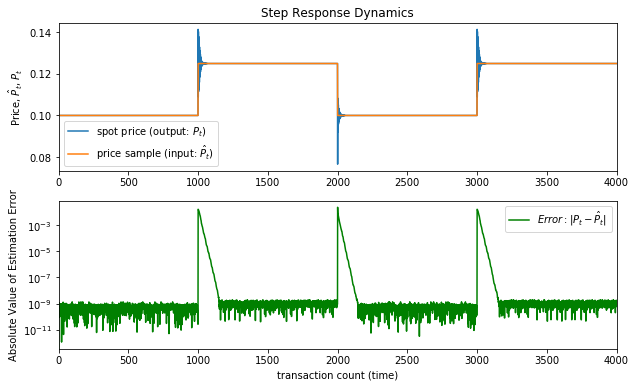

In [23]:
response_plot(df[df.rule=='step'], "Step")

The Square-Wave response above shows that the step response is tightly tuned, resulting in a large overshoot but remaining stable, oscillating and converging quickly. This behavior is characteristic of a high gain proportional controller. 

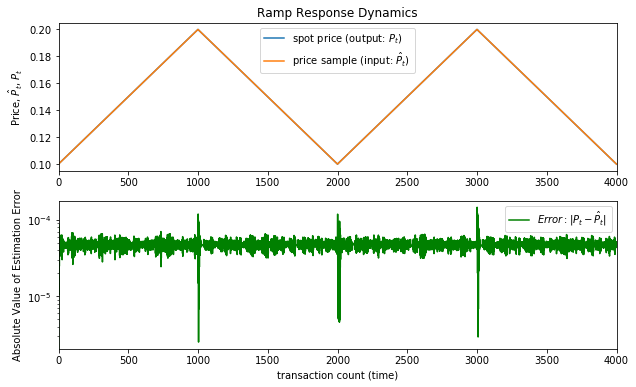

In [24]:
response_plot(df[df.rule=='ramp'], "Ramp")

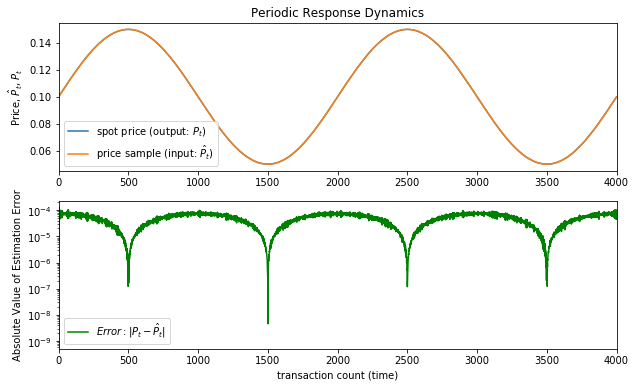

In [25]:
response_plot(df[df.rule=='sin'], "Periodic")

The Triangle-Wave and Sine-Wave signals are equally reminiscent of such a controller; the Triangle-Wave exhibits steady state error during the ramp and the Sine-Wave tracks most closely at the peaks and troughs.

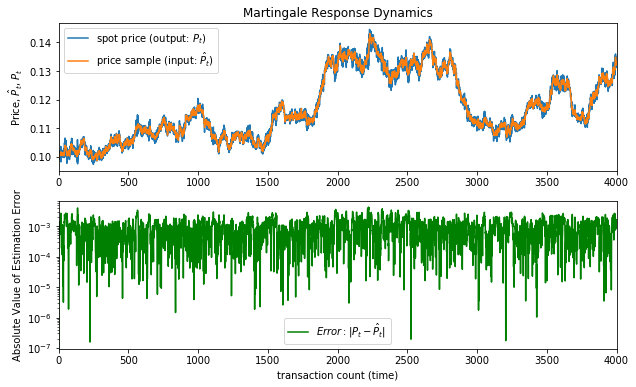

In [26]:
response_plot(df[df.rule=='martin'], "Martingale")

In the Random Walk tracking behavior is observed, but the error radius appears large. Despite the high frequency noise, the error does not appear to accumulate, and does appear to remain within a ball roughly on the order of $3\sigma$, likely an artifact of the random walk whereby $\frac{\Delta \hat P_t}{\hat P_t} \sim N(0,\sigma)$ for all $t$.